## **Post-Event Analysis: Average Future Moves After >5% Absolute Daily Change**

/tmp/ipython-input-1251269349.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, progress=False)['Close']



Frequency of Daily Changes - Percentage of Days (2011 to today):

|  Daily Change %  |   VOO % |   QQQ % |   V % |   MSFT % |   GOOG % |
|:----------------:|--------:|--------:|------:|---------:|---------:|
|  More than -5%   |    0.19 |    0.27 |   0.4 |     0.54 |     0.84 |
|    -5% to -3%    |    1.05 |    1.78 |  2.13 |     2.37 |     2.78 |
|    -3% to -1%    |     9.6 |   12.72 | 15.53 |    15.39 |    16.55 |
|    -1% to 1%     |   76.28 |   67.41 | 61.29 |    58.44 |    55.74 |
|     1% to 3%     |   12.13 |   16.36 | 18.36 |    20.35 |    20.67 |
|     3% to 5%     |    0.51 |    1.16 |  1.81 |     2.16 |     2.48 |
|   More than 5%   |    0.24 |     0.3 |  0.49 |     0.75 |     0.94 |

Frequency of Daily Changes - Count/Total Days (2011 to today):

|  Daily Change %  |  VOO Count/Total  |  QQQ Count/Total  |  V Count/Total  |  MSFT Count/Total  |  GOOG Count/Total  |
|:----------------:|:-----------------:|:-----------------:|:---------------:|:------------------:|:--------

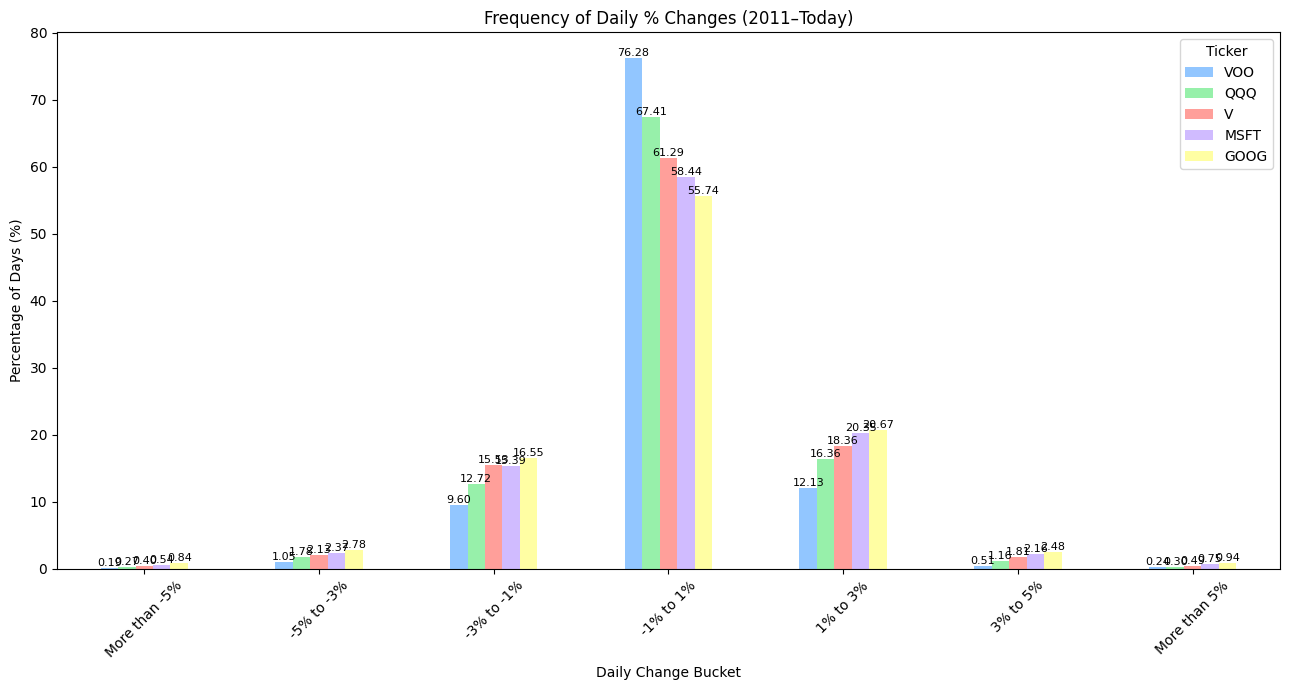

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

tickers = ['VOO', 'QQQ', 'V', 'MSFT', 'GOOG']
start_date = '2011-01-01'

data = yf.download(tickers, start=start_date, progress=False)['Close']
daily_change = data.pct_change() * 100
plt.style.use("seaborn-v0_8-pastel")

# Threshold Buckets
thresholds = {
    'More than -5%': lambda x: (x < -5),
    '-5% to -3%': lambda x: (-5 <= x < -3),
    '-3% to -1%': lambda x: (-3 <= x < -1),
    '-1% to 1%': lambda x: (-1 <= x <= 1),
    '1% to 3%': lambda x: (1 < x <= 3),
    '3% to 5%': lambda x: (3 < x <= 5),
    'More than 5%': lambda x: (x > 5)
}

perc_data = {}
count_data = {}
index = list(thresholds.keys())

for ticker in tickers:
    total_days = daily_change[ticker].count()
    perc_col = []
    count_col = []
    for threshold, condition in thresholds.items():
        count = daily_change[ticker].apply(condition).sum()
        perc_col.append(round((count / total_days) * 100, 2))
        count_col.append(f"{count}/{total_days}")

    perc_data[f"{ticker} %"] = perc_col
    count_data[f"{ticker} Count/Total"] = count_col

frequency_table_perc = pd.DataFrame(perc_data, index=index)
frequency_table_count = pd.DataFrame(count_data, index=index)

frequency_table_perc.index.name = 'Daily Change %'
frequency_table_count.index.name = 'Daily Change %'

print("\nFrequency of Daily Changes - Percentage of Days (2011 to today):\n")
print(frequency_table_perc.to_markdown(numalign="right", stralign="center"))

print("\nFrequency of Daily Changes - Count/Total Days (2011 to today):\n")
print(frequency_table_count.to_markdown(numalign="right", stralign="center"))
print(f"\n.")

ax = pd.DataFrame({
    t: frequency_table_perc[f"{t} %"] for t in tickers
}, index=frequency_table_perc.index).plot(kind="bar", figsize=(13,7))

plt.title("Frequency of Daily % Changes (2011–Today)")
plt.ylabel("Percentage of Days (%)")
plt.xlabel("Daily Change Bucket")
plt.xticks(rotation=45)
plt.legend(title="Ticker")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=8)

plt.tight_layout()
plt.show()

In [2]:
# ============================================================================
# BLOCK 2
# ============================================================================

print("- - - TOP 10 LARGEST DAILY CHANGES - - -")

for ticker in tickers:
    top_10_pos = daily_change[ticker].nlargest(10).round(2)
    top_10_neg = daily_change[ticker].nsmallest(10).round(2)

    combined_table = pd.DataFrame({
        "Date (+)": top_10_pos.index.strftime('%Y-%m-%d').values,
        "Change % (+)": top_10_pos.values,
        "Date (-)": top_10_neg.index.strftime('%Y-%m-%d').values,
        "Change % (-)": top_10_neg.values
    })

    print(f"\n======== {ticker} ========")
    print(combined_table.to_markdown(index=False, floatfmt=".2f"))
    print("\n" + "-"*60)


- - - TOP 10 LARGEST DAILY CHANGES - - -

======== VOO ========
| Date (+)   |   Change % (+) | Date (-)   |   Change % (-) |
|:-----------|---------------:|:-----------|---------------:|
| 2020-03-24 |           9.54 | 2020-03-16 |         -11.74 |
| 2020-03-13 |           9.34 | 2020-03-12 |          -9.67 |
| 2025-04-09 |           9.27 | 2020-03-09 |          -7.72 |
| 2020-04-06 |           6.80 | 2011-08-08 |          -6.41 |
| 2020-03-17 |           6.55 | 2025-04-04 |          -5.80 |
| 2020-03-26 |           6.01 | 2020-06-11 |          -5.76 |
| 2022-11-10 |           5.47 | 2020-03-18 |          -5.47 |
| 2020-03-10 |           5.13 | 2020-03-11 |          -4.96 |
| 2018-12-26 |           5.06 | 2025-04-03 |          -4.77 |
| 2011-08-09 |           4.48 | 2011-08-04 |          -4.68 |

------------------------------------------------------------

======== QQQ ========
| Date (+)   |   Change % (+) | Date (-)   |   Change % (-) |
|:-----------|---------------:|:-----------|-

In [3]:
# ============================================================================
# BLOCK 3
# ============================================================================

print("- - - POST-EVENT ANALYSIS RESULTS - - -")

horizons = {
    "1 week": 5,
    "2 weeks": 10,
    "1 month": 21,
    "3 months": 63,
    "1 year": 252
}

for ticker in tickers:
    returns = daily_change[ticker]
    pos_events = returns[returns > 5]
    neg_events = returns[returns < -5]

    def avg_future_return(events, horizon):
        results = []
        for date in events.index:
            future_window = data[ticker].loc[date:].iloc[:horizon+1]
            if len(future_window) == horizon + 1:
                start_price = future_window.iloc[0]
                end_price = future_window.iloc[-1]
                results.append((end_price / start_price - 1) * 100)
        return pd.Series(results).mean() if results else None

    pos_results = [avg_future_return(pos_events, days) for days in horizons.values()]
    neg_results = [avg_future_return(neg_events, days) for days in horizons.values()]

    combined_analysis_table = pd.DataFrame({
        'Positive Events (>5%)': [f"{r:.2f}%" if r is not None else "No data" for r in pos_results],
        'Negative Events (<-5%)': [f"{r:.2f}%" if r is not None else "No data" for r in neg_results]
    }, index=horizons.keys())

    print(f"\n======== {ticker} ========")
    print(combined_analysis_table.to_markdown(numalign="right", stralign="center"))
    print("-"*60)

- - - POST-EVENT ANALYSIS RESULTS - - -

======== VOO ========
|          |  Positive Events (>5%)  |  Negative Events (<-5%)  |
|:--------:|:-----------------------:|:------------------------:|
|  1 week  |         -2.79%          |          -0.40%          |
| 2 weeks  |          0.76%          |          0.66%           |
| 1 month  |          6.12%          |          9.72%           |
| 3 months |         16.59%          |          20.92%          |
|  1 year  |         45.66%          |          51.95%          |
------------------------------------------------------------

======== QQQ ========
|          |  Positive Events (>5%)  |  Negative Events (<-5%)  |
|:--------:|:-----------------------:|:------------------------:|
|  1 week  |         -2.54%          |          -0.90%          |
| 2 weeks  |         -0.45%          |          -2.41%          |
| 1 month  |          5.96%          |          4.56%           |
| 3 months |         21.32%          |          18.49%       

**Insights:**
- This result can be used as trading strategies (eg. it is not a good idea to LONG VOO or QQQ in short-term after an event of >5% rise).

## **Post-Event Analysis: Average Future Moves After RSI(14) Oversold & Overbought**

In [4]:
pip install TA-Lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 38.7 MB/s eta 0:00:00


/tmp/ipython-input-484852805.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, progress=False)['Close']



Frequency of RSI(14) Levels - Percentage of Days (2011 to today):

|      RSI(14) Level      |   VOO % |   QQQ % |   V % |   MSFT % |   GOOG % |
|:-----------------------:|--------:|--------:|------:|---------:|---------:|
|  < 20 (Super Oversold)  |    0.16 |    0.05 |     0 |        0 |        0 |
|          20-25          |     0.3 |    0.27 |  0.19 |     0.05 |     0.24 |
|          25-30          |       1 |    0.89 |  0.49 |     0.89 |     1.38 |
|          70-75          |    6.44 |    7.98 |  5.63 |     6.74 |     6.06 |
|          75-80          |    1.87 |       3 |  1.95 |     3.11 |     2.11 |
|          80-85          |     0.6 |    0.73 |   0.6 |      0.6 |     1.05 |
| > 85 (Super Overbought) |    0.03 |    0.05 |  0.05 |     0.05 |     0.35 |


Frequency of RSI(14) Levels - Count/Total Days (2011 to today):

|      RSI(14) Level      |  VOO Count/Total  |  QQQ Count/Total  |  V Count/Total  |  MSFT Count/Total  |  GOOG Count/Total  |
|:-----------------------:|:-------

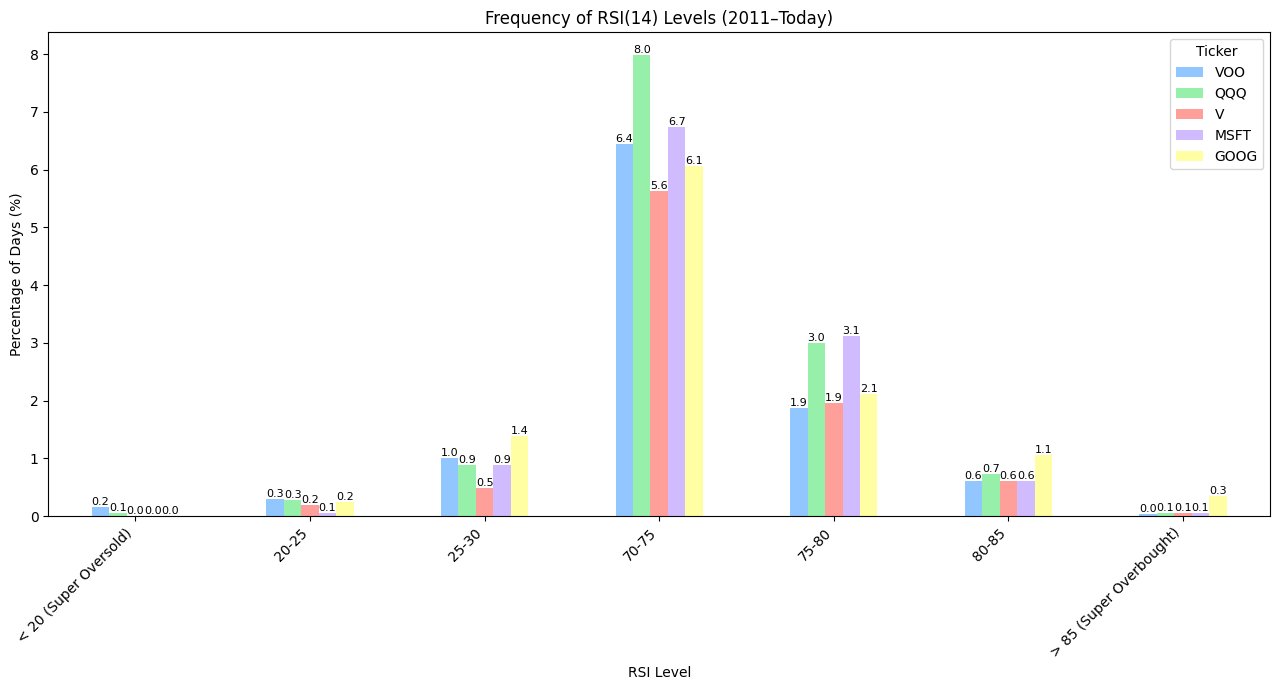

In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib
from IPython.display import display

tickers = ['VOO', 'QQQ', 'V', 'MSFT', 'GOOG']
start_date = '2011-01-01'
plt.style.use("seaborn-v0_8-pastel")

data = yf.download(tickers, start=start_date, progress=False)['Close']
daily_change = data.pct_change() * 100

rsi_data = pd.DataFrame()
for ticker in tickers:
    rsi_data[ticker] = talib.RSI(data[ticker], timeperiod=14)

rsi_thresholds = {
    '< 20 (Super Oversold)': lambda x: (x < 20),
    '20-25': lambda x: (20 <= x < 25),
    '25-30': lambda x: (25 <= x < 30),
    '70-75': lambda x: (70 < x <= 75),
    '75-80': lambda x: (75 < x <= 80),
    '80-85': lambda x: (80 < x <= 85),
    '> 85 (Super Overbought)': lambda x: (x > 85)
}

perc_data = {}
count_data = {}
index = list(rsi_thresholds.keys())

for ticker in tickers:
    total_days = rsi_data[ticker].count()
    perc_col = []
    count_col = []
    for threshold, condition in rsi_thresholds.items():
        count = rsi_data[ticker].apply(condition).sum()
        perc_col.append(round((count / total_days) * 100, 2))
        count_col.append(f"{count}/{int(total_days)}")

    perc_data[f"{ticker} %"] = perc_col
    count_data[f"{ticker} Count/Total"] = count_col

frequency_table_perc = pd.DataFrame(perc_data, index=index)
frequency_table_count = pd.DataFrame(count_data, index=index)

frequency_table_perc.index.name = 'RSI(14) Level'
frequency_table_count.index.name = 'RSI(14) Level'

print("\nFrequency of RSI(14) Levels - Percentage of Days (2011 to today):\n")
print(frequency_table_perc.to_markdown(numalign="right", stralign="center"))

print("\n\nFrequency of RSI(14) Levels - Count/Total Days (2011 to today):\n")
print(frequency_table_count.to_markdown(numalign="right", stralign="center"))
print(f"\n.")

ax = pd.DataFrame({
    t: frequency_table_perc[f"{t} %"] for t in tickers
}, index=frequency_table_perc.index).plot(kind="bar", figsize=(13, 7))

plt.title("Frequency of RSI(14) Levels (2011–Today)")
plt.ylabel("Percentage of Days (%)")
plt.xlabel("RSI Level")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Ticker")

for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", label_type="edge", fontsize=8)

plt.tight_layout()
plt.show()

In [6]:
# ============================================================================
# BLOCK 2
# ============================================================================

print("\n- - - TOP 10 HIGHEST & LOWEST RSI(14) - - -")

for ticker in tickers:
    top_10_high = rsi_data[ticker].nlargest(10).round(2)
    top_10_low = rsi_data[ticker].nsmallest(10).round(2)

    combined_table = pd.DataFrame({
        "Date (High RSI)": top_10_high.index.strftime('%Y-%m-%d').values,
        "RSI Level (High)": top_10_high.values,
        "Date (Low RSI)": top_10_low.index.strftime('%Y-%m-%d').values,
        "RSI Level (Low)": top_10_low.values
    })

    print(f"\n======== {ticker} ========")
    print(combined_table.to_markdown(index=False, floatfmt=".2f"))
    print("\n" + "-"*60)



- - - TOP 10 HIGHEST & LOWEST RSI(14) - - -

======== VOO ========
| Date (High RSI)   |   RSI Level (High) | Date (Low RSI)   |   RSI Level (Low) |
|:------------------|-------------------:|:-----------------|------------------:|
| 2018-01-26        |              87.27 | 2011-08-08       |             16.75 |
| 2018-01-23        |              84.67 | 2015-08-25       |             16.99 |
| 2018-01-12        |              84.32 | 2018-10-11       |             18.06 |
| 2018-01-22        |              84.02 | 2015-08-24       |             18.41 |
| 2018-01-25        |              84.01 | 2018-12-24       |             19.20 |
| 2018-01-24        |              83.86 | 2020-02-28       |             19.56 |
| 2017-03-01        |              82.68 | 2020-02-27       |             20.29 |
| 2020-09-02        |              82.47 | 2025-04-08       |             21.51 |
| 2017-02-27        |              82.08 | 2018-12-21       |             22.50 |
| 2018-01-11        |         

In [7]:
# ============================================================================
# BLOCK 3
# ============================================================================

print("\n- - - POST-EVENT ANALYSIS RESULTS - - -")

horizons = {
    "1 week": 5,
    "2 weeks": 10,
    "1 month": 21,
    "3 months": 63,
    "1 year": 252
}

for ticker in tickers:
    oversold_lt20 = rsi_data[ticker][rsi_data[ticker] < 20]
    oversold_20_25 = rsi_data[ticker][(rsi_data[ticker] >= 20) & (rsi_data[ticker] < 25)]
    oversold_25_30 = rsi_data[ticker][(rsi_data[ticker] >= 25) & (rsi_data[ticker] < 30)]
    overbought_75_80 = rsi_data[ticker][(rsi_data[ticker] > 75) & (rsi_data[ticker] <= 80)]
    overbought_80_85 = rsi_data[ticker][(rsi_data[ticker] > 80) & (rsi_data[ticker] <= 85)]
    overbought_gt85 = rsi_data[ticker][rsi_data[ticker] > 85]

    def avg_future_return(events, horizon):
        results = []
        for date in events.index:
            try:
                date_loc = data.index.get_loc(date)
                if date_loc + horizon < len(data):
                    start_price = data[ticker].iloc[date_loc]
                    end_price = data[ticker].iloc[date_loc + horizon]
                    if pd.notna(start_price) and pd.notna(end_price) and start_price != 0:
                        results.append((end_price / start_price - 1) * 100)
            except:
                continue
        return pd.Series(results).mean() if results else None

    results_dict = {
        'RSI <20': [],
        'RSI 20-25': [],
        'RSI 25-30': [],
        'RSI 75-80': [],
        'RSI 80-85': [],
        'RSI >85': []
    }

    for days in horizons.values():
        results_dict['RSI <20'].append(avg_future_return(oversold_lt20, days))
        results_dict['RSI 20-25'].append(avg_future_return(oversold_20_25, days))
        results_dict['RSI 25-30'].append(avg_future_return(oversold_25_30, days))
        results_dict['RSI 75-80'].append(avg_future_return(overbought_75_80, days))
        results_dict['RSI 80-85'].append(avg_future_return(overbought_80_85, days))
        results_dict['RSI >85'].append(avg_future_return(overbought_gt85, days))

    analysis_table = pd.DataFrame(results_dict, index=horizons.keys())

    formatted_table = analysis_table.applymap(
        lambda x: f"{x:.2f}%" if pd.notna(x) else "NaN"
    )

    event_counts = pd.DataFrame({
        'RSI <20': [f"n={len(oversold_lt20)}"],
        'RSI 20-25': [f"n={len(oversold_20_25)}"],
        'RSI 25-30': [f"n={len(oversold_25_30)}"],
        'RSI 75-80': [f"n={len(overbought_75_80)}"],
        'RSI 80-85': [f"n={len(overbought_80_85)}"],
        'RSI >85': [f"n={len(overbought_gt85)}"]
    }, index=['Total Count'])

    print(f"\n\n======== {ticker} ========")
    print(event_counts.to_markdown(numalign="center", stralign="center"))
    print()
    print(formatted_table.to_markdown(numalign="right", stralign="center"))
    print("-" * 60)

print("\n- - - 📊 SUMMARY: RSI EVENT FREQUENCIES - - -\n")
summary_counts = pd.DataFrame({
    ticker: [
        len(rsi_data[ticker][rsi_data[ticker] < 20]),
        len(rsi_data[ticker][(rsi_data[ticker] >= 20) & (rsi_data[ticker] < 25)]),
        len(rsi_data[ticker][(rsi_data[ticker] >= 25) & (rsi_data[ticker] < 30)]),
        len(rsi_data[ticker][(rsi_data[ticker] > 75) & (rsi_data[ticker] <= 80)]),
        len(rsi_data[ticker][(rsi_data[ticker] > 80) & (rsi_data[ticker] <= 85)]),
        len(rsi_data[ticker][rsi_data[ticker] > 85])
    ] for ticker in tickers
}, index=['RSI <20', 'RSI 20-25', 'RSI 25-30',
          'RSI 75-80', 'RSI 80-85', 'RSI >85'])

print(summary_counts.to_markdown(numalign="center"))


- - - POST-EVENT ANALYSIS RESULTS - - -


======== VOO ========
|             |  RSI <20  |  RSI 20-25  |  RSI 25-30  |  RSI 75-80  |  RSI 80-85  |  RSI >85  |
|:-----------:|:---------:|:-----------:|:-----------:|:-----------:|:-----------:|:---------:|
| Total Count |    n=6    |    n=11     |    n=37     |    n=69     |    n=22     |    n=1    |

|          |  RSI <20  |  RSI 20-25  |  RSI 25-30  |  RSI 75-80  |  RSI 80-85  |  RSI >85  |
|:--------:|:---------:|:-----------:|:-----------:|:-----------:|:-----------:|:---------:|
|  1 week  |   3.83%   |    2.73%    |    1.60%    |   -0.13%    |    0.24%    |  -3.86%   |
| 2 weeks  |   1.58%   |   -0.28%    |    1.45%    |    0.01%    |   -0.93%    |  -8.70%   |
| 1 month  |   3.00%   |    2.93%    |    2.37%    |    0.05%    |   -2.26%    |  -4.26%   |
| 3 months |   9.07%   |    9.61%    |    7.26%    |    0.90%    |   -0.12%    |  -6.58%   |
|  1 year  |  25.03%   |   19.23%    |   21.34%    |   13.85%    |    6.55%    |  -6.28%

/tmp/ipython-input-3249549607.py:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_table = analysis_table.applymap(




======== MSFT ========
|             |  RSI <20  |  RSI 20-25  |  RSI 25-30  |  RSI 75-80  |  RSI 80-85  |  RSI >85  |
|:-----------:|:---------:|:-----------:|:-----------:|:-----------:|:-----------:|:---------:|
| Total Count |    n=0    |     n=2     |    n=33     |    n=115    |    n=22     |    n=2    |

|          |   RSI <20 |  RSI 20-25  |  RSI 25-30  |  RSI 75-80  |  RSI 80-85  |  RSI >85  |
|:--------:|----------:|:-----------:|:-----------:|:-----------:|:-----------:|:---------:|
|  1 week  |       nan |    3.14%    |    2.96%    |    0.03%    |   -1.01%    |   0.54%   |
| 2 weeks  |       nan |    6.65%    |    2.27%    |    0.77%    |   -2.00%    |   0.06%   |
| 1 month  |       nan |    6.08%    |    3.93%    |    1.76%    |   -1.92%    |   0.81%   |
| 3 months |       nan |   19.42%    |    7.94%    |    2.14%    |    3.36%    |  12.52%   |
|  1 year  |       nan |   39.97%    |   34.58%    |   14.34%    |   24.97%    |  26.01%   |
-----------------------------------

**Future Improvement - Compute:**

- Three/Four/Five-day consecutive drops
- One week/month cumulatively drop 10%